In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import datetime
from sklearn import preprocessing


In [ ]:
offValues = {2859:{'air1':0.2, 'furnace1':0.2, 'refrigerator1':0.1, 'clotheswasher1':0.2, 
                    'drye1':1, 'dishwasher1':0, 'kitchenapp1':0.005,  'microwave1':0.25},
             6990:{'air1':1, 'furnace1':0.3, 'refrigerator1':0.1, 'clotheswasher1':0.2, 
                    'drye1':2, 'dishwasher1':0.5, 'kitchenapp1':0.1,  'microwave1':0.05},
             7951:{'air1':0.5, 'furnace1':0.01, 'refrigerator1':0.1, 'clotheswasher1':0.1, 
                    'drye1':1, 'dishwasher1':0.4, 'kitchenapp1':0.2,  'microwave1':0.5},
             8292:{'air1':0.3, 'furnace1':0.2, 'refrigerator1':0.2, 'clotheswasher1':0.05, 
                    'drye1':1, 'dishwasher1':0.5, 'kitchenapp1':0.01,  'microwave1':0.5},
             3413:{'air1':0.3, 'furnace1':0.3, 'refrigerator1':0.1, 'clotheswasher1':0.1, 
                    'drye1':1, 'dishwasher1':0.5, 'kitchenapp1':0.4,  'microwave1':0.25}}

#2859:{0:0,1:0.007,2:0.003,3:0.1,4:0,5:0,6:0,7:0.008}
class ReaderTS(object):

    def __init__(self, windows, appliances, time_steps, strd_in, strd_out, 
                    sample_period, flgAggSumScaled=0, flgFilterZeros = 0, 
                    flgScaling=0, trainPer=0.5, valPer=0.25, testPer=0.25):
        self.stride_input = strd_in
        self.stride_output = strd_out
        self.time_steps = time_steps
        self.pTrain = trainPer
        self.pVal = valPer
        self.pTest = testPer
        self.listAppliances = appliances
        self.windows = windows
        self.sample_period = sample_period
        self.flgScaling = flgScaling
        self.flgAggSumScaled = flgAggSumScaled
        self.flgFilterZeros = flgFilterZeros
        self.bin_edges = None
        self.idxFiltered = []
        assert (trainPer+valPer+testPer) == 1
        
    def rnn_data( self, data, idxStart, idxEnd, apps, stride, labels=False):
        rnn_df = []

        if labels:
            data = data[apps].values
            arrShape = [0,self.time_steps,len(apps)]
        else:
            data = data['use'].values
            arrShape = [0,self.time_steps]

        for i in range(idxStart, idxEnd, stride): # not a-b because we take all the examples
            seqY = data[i:i + self.time_steps]
            if (seqY.shape[0] == self.time_steps):
                rnn_df.append(seqY)
            else:
                continue #pad

        if (len(rnn_df)!=0):
            result = np.array(rnn_df) #shape (batch, x:1/y:apps, lengthSeq)
            return np.squeeze(result) # make it two dimensions if we are just selecting one appliance
        else:
            return np.empty(arrShape)
    
    def calculate_split(self, data):
        '''
        Spliting the data into training, validation and test sets according to the percentage values
        '''
        pRest = self.pVal + self.pTest
        completeInstances = len(data.index)
        print(completeInstances)
        indexVal = int(round((self.pTrain*self.stride_input*completeInstances / ( pRest*self.stride_output +self.pTrain*self.stride_input))))
        indexTest = int(indexVal + self.pVal*(completeInstances - indexVal)/pRest)

        #Sabina 50% - 25% - 25%
        return indexVal,indexTest,completeInstances
    
    def split_data(self, dataBuild, indexVal, indexTest, indexEnd,apps):
        train_y = self.rnn_data(dataBuild, 0, (indexVal), apps, self.stride_input, labels=True)
        val_y   = self.rnn_data(dataBuild, indexVal, indexTest, apps, self.stride_output, labels=True)
        test_y  = self.rnn_data(dataBuild, indexTest, indexEnd, apps, self.stride_output, labels=True)
        return train_y, val_y, test_y

    def scaling(self, train, val, test, newShape, thirdDim):
            ##### scaling
        flat_train = np.reshape(train,[-1,thirdDim])
        flat_val = np.reshape(val,[-1,thirdDim])
        flat_test = np.reshape(test,[-1,thirdDim])

        scalerY = preprocessing.StandardScaler().fit(flat_train)

        train = scalerY.transform(flat_train) if flat_train.shape[0]!=0 else train
        train = np.reshape(train, newShape)
        val = scalerY.transform(flat_val) if flat_val.shape[0]!=0 else val
        val = np.reshape(val, newShape)
        test = scalerY.transform(flat_test) if flat_test.shape[0]!=0 else test
        test = np.reshape(test, newShape)
        return train, val, test      

    def filtering_zeros(self,dataset):
        '''
        Eliminating sequences where all the time_steps are 0
        '''
        sumZero = np.sum(dataset, axis=1)
        idxNonZero = np.where(sumZero>0)
        return dataset[idxNonZero], idxNonZero

    def filtering_Off(self,dataset, building):
        '''
        Eliminating sequences where all the time_steps are equal to value that can be considered OFF
        '''
        #assert len(self.listAppliances)==len(offValues[building])
        cond=[]
        for idx, app in enumerate(self.listAppliances):
            cond.append(dataset[:,:,idx]>offValues[building][app])#,dataset[:,1]>0]
        condArray = np.array(cond)
        print("cond array shape ",condArray.shape)
        goodRows = np.any(condArray,axis=0)
        #print("1st filter ", goodRows.shape)
        goodRows = np.any(goodRows,axis=1)
        #print("2nd filter ", goodRows.shape)
        idxNonZero = np.where(goodRows==True)
        print("len index ", len(idxNonZero), " shape ", len(idxNonZero[0]))
        return dataset[idxNonZero], idxNonZero

    def prepare_data(self, dataBuild, numApp, building):
        '''
        Spliting to scale over the training
        Filtering zeros before scaling
        Two ways:
            - when requiring just one appliance: spliting the disaggregated, 
                                                filtering zeros from disaggregated and then aggregated 
                                                scaling separetly
            - when requiring all the appliances: spliting the disaggregated,
                                                Calculating aggregated
                                                Filter zeros from aggregated and the disaggregated
                                                Scaling disaggregated
                                                Suming up aggregated from the scaled disaggregated
        '''
        indexVal, indexTest, indexEnd = self.calculate_split(dataBuild)
        print("Indexes: ",indexVal, indexTest, indexEnd)
        self.bin_edges = np.array([0,indexVal, indexTest, indexEnd])
        #Split and sum as if there was no specific appliance selected
        train_y, val_y, test_y = self.split_data(dataBuild, indexVal, indexTest, indexEnd, self.listAppliances)

        #sum up to calculate aggregation (x)
        train_x = np.sum(train_y, axis=2)
        val_x   = np.sum(val_y, axis=2)
        test_x  = np.sum(test_y, axis=2)

        print("Shapes before filtering ",train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
            
        if (numApp != -1):# if one specific appliance is selected
            #plt.figure(1)
            #plt.plot(dataBuild[self.listAppliances[numApp]][indexTest:])
            
            shapeY = [-1,self.time_steps]
            shapeX = [-1,self.time_steps]

            train_y, val_y, test_y = train_y[:,:,numApp], val_y[:,:,numApp], test_y[:,:,numApp]
            #Filtering zeros of specific appliance and respective aggregated instance

            if (self.flgFilterZeros==1):
                train_y, idxTrain = self.filtering_zeros(train_y)
                val_y, idxVal   = self.filtering_zeros(val_y)
                test_y, idxTest  = self.filtering_zeros(test_y)

                train_x = train_x[idxTrain]
                val_x   = val_x[idxVal]
                test_x  = test_x[idxTest]
            print("Shapes after filtering for one app ",train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

            #Scaling
            lenApps=1
            
            train_y, val_y, test_y = self.scaling(train_y, val_y, test_y, shapeY, thirdDim = lenApps)
            if (self.flgAggSumScaled==1):
                pass # See the way to scale all x sets with respect to train_y
            train_x, val_x, test_x = self.scaling(train_x, val_x, test_x, shapeX, thirdDim = 1)
            
        else:
            lenApps = len(self.listAppliances)
            shapeY = [-1,self.time_steps, lenApps]
            shapeX = [-1,self.time_steps]

            #Filtering aggregated sequence with no information at all
            if (self.flgFilterZeros==1):
                '''
                train_x, idxTrain = self.filtering_zeros(train_x)
                val_x, idxVal   = self.filtering_zeros(val_x)
                test_x, idxTest  = self.filtering_zeros(test_x)
                '''
                train_y, idyTrain=self.filtering_Off(train_y, building)
                val_y, idyVal   = self.filtering_Off(val_y, building)
                test_y, idyTest  = self.filtering_Off(test_y, building)
                #Filtering the same instances in the disaggregated data set
                train_x = train_x[idyTrain]
                val_x   = val_x[idyVal]
                test_x  = test_x[idyTest]

            #Scaled each disaggregated separetly and recalculating aggregated consumption
            train_y, val_y, test_y = self.scaling(train_y, val_y, test_y, shapeY, thirdDim = lenApps)

            if (self.flgAggSumScaled ==1):
                train_x = np.sum(train_y, axis=2)
                val_x   = np.sum(val_y, axis=2)
                test_x  = np.sum(test_y, axis=2)
            else:
                train_x, val_x, test_x = self.scaling(train_x, val_x, test_x, shapeX, thirdDim = 1)
            print("Shapes after filtering all at once ",train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
        return [train_x, val_x, test_x, train_y, val_y, test_y]


    def load_csvdata(self, path, numApp):#appliances, filename, self.sample_period, windows
        '''
        Parameters:
            fileName
            numApp to indicate wether all the appliances should be read or just one of them

        Returns:
            totalX, totalY two dictionaries with the split of the X and Y in training, validation and testing
        '''        
        #homes = ["2859","3413","6990","7951","8292"] # collection of home id availables
        #home = homes[0]
        isMinutes = True
        lenApps = len(self.listAppliances)
        shapeY = [0,self.time_steps,lenApps] # (batch, seqLen, apps)
        
        if (numApp!=-1):
            lenApps = 1
            shapeY = [0,self.time_steps]
        totalX = {'train':np.empty([0,self.time_steps]), 
                    'val':np.empty([0,self.time_steps]),
                    'test':np.empty([0,self.time_steps])}

        totalY = {'train':np.empty(shapeY), 
                    'val':np.empty(shapeY),
                    'test':np.empty(shapeY)}

        for building_i, window in self.windows.items():
            flgNewLoad = 0
            print(building_i)
            try:
                if (numApp!=-1):
                    truFileName=str(building_i)+'_'+self.listAppliances[numApp]+'_'+'_'+window[0]+'_'+window[1]#fileName[pos:]
                else:
                    truFileName=str(building_i)+'_'+'all'+'_'+'_'+window[0]+'_'+window[1]
                allSetsBuild = []*len(self.listAppliances)
                X = pickle.load( open(path+"/pickles/"+truFileName+"_X.pickle","rb"))
                Y = pickle.load( open(path+"/pickles/"+truFileName+"_Y.pickle","rb"))
                allSetsBuild = X['train'], X['val'],X['test'], Y['train'], Y['val'], Y['test']
            except (OSError, IOError) as e:
                if(isMinutes):
                    imagepath=path+"/dataid_{}_minute.h5".format(building_i) 
                else:
                    imagepath=path+"/dataid_{}_hour.h5".format(building_i)
                #print(imagepath)
                imagearray  = pd.HDFStore(imagepath)
                #print imagearray.keys()
                data=imagearray['df']
                data = data.loc[data.index < window[1]]
                data = data.loc[data.index > window[0]]
                allSetsBuild = self.prepare_data(data, numApp,building_i)
            totalX['train'] = np.concatenate((totalX['train'], allSetsBuild[0]),axis=0)
            totalX['val'] = np.concatenate((totalX['val'], allSetsBuild[1]),axis=0)
            totalX['test'] = np.concatenate((totalX['test'], allSetsBuild[2]),axis=0)
            totalY['train'] = np.concatenate((totalY['train'], allSetsBuild[3]),axis=0)
            totalY['val'] = np.concatenate((totalY['val'], allSetsBuild[4]),axis=0)
            totalY['test'] = np.concatenate((totalY['test'], allSetsBuild[5]),axis=0)
            print("One more building ", totalX['train'].shape, totalX['val'].shape, totalX['test'].shape, totalY['train'].shape, totalY['val'].shape, totalY['test'].shape)

            if (flgNewLoad==1):
                with open(path+"/pickles/"+truFileName+"_X.pickle",'wb') as fX:
                    pickle.dump(totalX, fX)
                with open(path+"/pickles/"+truFileName+"_Y.pickle",'wb') as fY:
                    pickle.dump(totalY,fY)
            #os.makedirs(os.path.dirname(cwd+"/pickles/"+truFileName))
            #os.makedirs(os.path.dirname(cwd+"/pickles/"+truFileName))
            #this assumes you have a "pickles" directory at the same level as this file
        print(totalX['train'].shape, totalX['val'].shape, totalX['test'].shape, totalY['train'].shape, totalY['val'].shape, totalY['test'].shape)
        print(data.dtypes)
        return totalX, totalY

In [23]:
appliances = ['air1', 'furnace1']
#'refrigerator1',  'clotheswasher1','drye1','dishwasher1', 'kitchenapp1', 'microwave1'
windows = {6990:("2015-01-01", "2015-12-31"), 2859:("2015-01-01", "2015-12-31"), 7951:("2015-01-01", "2015-12-31"),8292:("2015-01-01", "2015-12-31"),3413:("2015-01-01", "2015-12-31")}#3413:("2015-06-01", "2015-12-31")

reader = ReaderTS(windows, appliances,90,1,90,6,flgAggSumScaled=0, flgFilterZeros = 1, 
                    flgScaling=0, trainPer=0.5, valPer=0.25, testPer=0.25)
building = reader.load_csvdata('/home/gissella/Documents/Research/Disaggregation/PecanStreet-dataport/datasets/',-1)

2859
523799
('Indexes: ', 5756, 264777, 523799)
('Shapes before filtering ', (5756, 90), (2879, 90), (2878, 90), (5756, 90, 2), (2879, 90, 2), (2878, 90, 2))
('cond array shape ', (2, 5756, 90))
('len index ', 1, ' shape ', 3968)
('cond array shape ', (2, 2879, 90))
('len index ', 1, ' shape ', 691)
('cond array shape ', (2, 2878, 90))
('len index ', 1, ' shape ', 1455)
('Shapes after filtering all at once ', (3968, 90), (691, 90), (1455, 90), (3968, 90, 2), (691, 90, 2), (1455, 90, 2))
('One more building ', (3968, 90), (691, 90), (1455, 90), (3968, 90, 2), (691, 90, 2), (1455, 90, 2))
8292
523799
('Indexes: ', 5756, 264777, 523799)
('Shapes before filtering ', (5756, 90), (2879, 90), (2878, 90), (5756, 90, 2), (2879, 90, 2), (2878, 90, 2))
('cond array shape ', (2, 5756, 90))
('len index ', 1, ' shape ', 3838)
('cond array shape ', (2, 2879, 90))
('len index ', 1, ' shape ', 1095)
('cond array shape ', (2, 2878, 90))
('len index ', 1, ' shape ', 1380)
('Shapes after filtering all at 

In [24]:
np.round(building[0]['train'],2)

array([[-0.62, -0.62, -0.62, ..., -0.62, -0.18,  1.87],
       [-0.62, -0.62, -0.62, ..., -0.18,  1.87,  1.83],
       [-0.62, -0.62, -0.62, ...,  1.87,  1.83,  1.81],
       ..., 
       [ 2.67,  2.67,  2.65, ..., -0.4 , -0.4 , -0.4 ],
       [ 2.67,  2.65,  0.05, ..., -0.4 , -0.4 , -0.4 ],
       [ 2.65,  0.05, -0.4 , ..., -0.4 , -0.4 , -0.4 ]])

In [3]:
imagearray2  = pd.HDFStore('/home/gissella/Documents/Research/Disaggregation/PecanStreet-dataport/datasets/dataid_6990_minute.h5')

In [4]:
data2 = imagearray2['df']
data2.loc[data2['dishwasher1']>0.8]

,use,air1,furnace1,refrigerator1,clotheswasher1,drye1,dishwasher1,kitchenapp1,microwave1
2015-01-04 18:31:00,1.949,0.0,0.010,0.020,0.0,0.0,1.054,0.000,0.003
2015-01-04 18:32:00,1.891,0.0,0.009,0.007,0.0,0.0,1.246,0.003,0.000
2015-01-04 18:33:00,1.791,0.0,0.009,0.006,0.0,0.0,1.121,0.003,0.003
2015-01-04 18:34:00,1.708,0.0,0.009,0.006,0.0,0.0,1.040,0.000,0.003
2015-01-04 18:35:00,1.906,0.0,0.009,0.007,0.0,0.0,1.240,0.003,0.000
2015-01-04 18:36:00,1.905,0.0,0.009,0.007,0.0,0.0,1.238,0.003,0.000
2015-01-04 18:37:00,1.615,0.0,0.009,0.006,0.0,0.0,0.911,0.000,0.004
2015-01-04 18:38:00,2.004,0.0,0.092,0.007,0.0,0.0,1.235,0.003,0.000
2015-01-04 18:39:00,2.406,0.0,0.525,0.007,0.0,0.0,1.234,0.003,0.000
2015-01-04 18:40:00,2.133,0.0,0.576,0.006,0.0,0.0,0.907,0.000,0.004


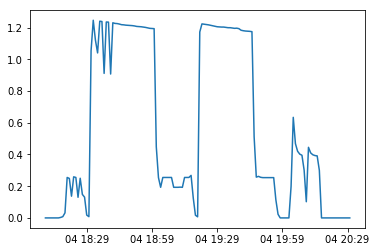

In [10]:
plt.figure(0)
plt.plot(data2['dishwasher1']['2015-01-04 18:10:00':'2015-01-04 20:30:00'])
#plt.figure(1)
#plt.plot(data2['drye1']['2015-01-02 19:40:00':'2015-01-02 21:55:00'])

In [11]:
data2['dishwasher1']['2015-01-04 18:10:00':'2015-01-04 20:30:00']

2015-01-04 18:10:00    0.000
2015-01-04 18:11:00    0.000
2015-01-04 18:12:00    0.000
2015-01-04 18:13:00    0.000
2015-01-04 18:14:00    0.000
2015-01-04 18:15:00    0.000
2015-01-04 18:16:00    0.000
2015-01-04 18:17:00    0.003
2015-01-04 18:18:00    0.008
2015-01-04 18:19:00    0.032
2015-01-04 18:20:00    0.255
2015-01-04 18:21:00    0.249
2015-01-04 18:22:00    0.137
2015-01-04 18:23:00    0.259
2015-01-04 18:24:00    0.255
2015-01-04 18:25:00    0.130
2015-01-04 18:26:00    0.250
2015-01-04 18:27:00    0.148
2015-01-04 18:28:00    0.131
2015-01-04 18:29:00    0.018
2015-01-04 18:30:00    0.008
2015-01-04 18:31:00    1.054
2015-01-04 18:32:00    1.246
2015-01-04 18:33:00    1.121
2015-01-04 18:34:00    1.040
2015-01-04 18:35:00    1.240
2015-01-04 18:36:00    1.238
2015-01-04 18:37:00    0.911
2015-01-04 18:38:00    1.235
2015-01-04 18:39:00    1.234
                       ...  
2015-01-04 20:01:00    0.000
2015-01-04 20:02:00    0.000
2015-01-04 20:03:00    0.199
2015-01-04 20:

In [12]:
import scipy.io
objMat = np.asarray(data2['dishwasher1']['2015-01-04 18:10:00':'2015-01-04 20:30:00'])
scipy.io.savemat('dishWashTS.mat', mdict={'dishWashTS':objMat })

In [17]:
data2 = imagearray2['df']
goodPlot = data2.loc[(data2['air1']>0.2) | (data2['furnace1']>0.2) | (data2['refrigerator1']>0.1) |
                     (data2['clotheswasher1']>0.2) | (data2['drye1']>1) | 
                     (data2['dishwasher1']>0) | (data2['kitchenapp1']>0) | (data2['microwave1']>0.008)]

#49
#& (data2['dishwasher1']>0)&(data2['kitchenapp1']>0)& (data2['microwave1']>0.008)
#len(data2) #525599
#len(goodPlot)
data2

,use,air1,furnace1,refrigerator1,clotheswasher1,drye1,dishwasher1,kitchenapp1,microwave1
2015-01-01 06:01:00,0.257,0.0,0.007,0.118,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:02:00,0.256,0.0,0.007,0.118,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:03:00,0.257,0.0,0.007,0.118,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:04:00,0.256,0.0,0.007,0.118,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:05:00,0.256,0.0,0.007,0.118,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:06:00,0.151,0.0,0.007,0.006,0.0,0.0,0.0,0.003,0.009
2015-01-01 06:07:00,0.148,0.0,0.007,0.003,0.0,0.0,0.0,0.003,0.009
2015-01-01 06:08:00,0.147,0.0,0.007,0.003,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:09:00,0.148,0.0,0.007,0.003,0.0,0.0,0.0,0.000,0.009
2015-01-01 06:10:00,0.147,0.0,0.007,0.003,0.0,0.0,0.0,0.003,0.009


In [730]:
imagearray  = pd.HDFStore('/home/gissella/Documents/Research/Disaggregation/PecanStreet-dataport/datasets/dataid_3413_minute.h5')

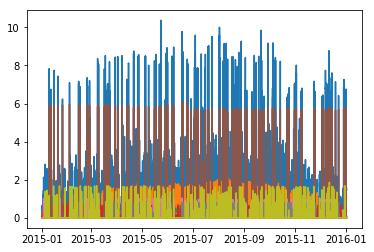

In [731]:
data=imagearray['df']
#data = data.loc[data.index < window[1]]
#data = data.loc[data.index > window[0]]
plt.figure(1)
plt.plot(data)

In [732]:
data.describe()

,use,air1,furnace1,refrigerator1,clotheswasher1,drye1,dishwasher1,kitchenapp1,microwave1
count,525599.000000,525599.000000,525599.000000,525599.000000,525599.000000,525599.000000,525599.000000,525599.000000,525599.000000
mean,0.985164,0.234193,0.342759,0.098666,0.001662,0.044364,0.008194,0.000777,0.006619
std,0.863176,0.543277,0.096114,0.085615,0.015114,0.467376,0.081771,0.020454,0.037588
min,0.000000,0.000000,0.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.553000,0.000000,0.333000,0.004000,0.000000,0.000000,0.000000,0.000000,0.005000
50%,0.633000,0.000000,0.340000,0.125000,0.000000,0.000000,0.000000,0.000000,0.005000
75%,0.979000,0.000000,0.346000,0.135000,0.000000,0.000000,0.000000,0.000000,0.005000
max,10.366000,2.112000,0.510000,0.838000,0.349000,6.088000,1.030000,0.834000,1.869000


In [814]:
data=imagearray['df']
#data = data.loc[data.index < window[1]]
#data = data.loc[data.index > '2015-06-01']
data.loc[(data['kitchenapp1']>0.4)]
#len(data.loc[(data['clotheswasher1']>0)&(data['clotheswasher1']<0.5)])
#kitchenapp 0:489814 - 0.003:3602 - 0.004:3589
#furnace 0: 290440 - 0.003:126297 - 0.004:19317
#kitchenapp 0:80681 -  0.003:256992 - 0.004:117941 - 0.005:44326 - 0.006:602
#microwave 0:299730 0.003:19729
#8292 clotheswasher 0:501308 0-0.5:24037

,use,air1,furnace1,refrigerator1,clotheswasher1,drye1,dishwasher1,kitchenapp1,microwave1
2015-01-17 01:35:00,1.921,0.0,0.341,0.136,0.000,0.012,0.0,0.819,0.005
2015-01-17 01:36:00,1.562,0.0,0.342,0.136,0.000,0.014,0.0,0.454,0.005
2015-01-17 01:40:00,1.940,0.0,0.341,0.146,0.000,0.012,0.0,0.818,0.005
2015-01-17 01:41:00,1.690,0.0,0.342,0.240,0.000,0.013,0.0,0.477,0.004
2015-01-17 19:47:00,1.554,0.0,0.339,0.186,0.000,0.008,0.0,0.813,0.005
2015-01-17 19:51:00,1.520,0.0,0.339,0.150,0.000,0.009,0.0,0.815,0.005
2015-01-17 19:52:00,1.276,0.0,0.340,0.150,0.000,0.010,0.0,0.573,0.005
2015-01-18 17:26:00,1.403,0.0,0.342,0.144,0.000,0.009,0.0,0.783,0.005
2015-01-18 17:27:00,1.318,0.0,0.342,0.149,0.000,0.009,0.0,0.695,0.005
2015-01-18 19:16:00,1.316,0.0,0.341,0.146,0.000,0.010,0.0,0.623,0.005


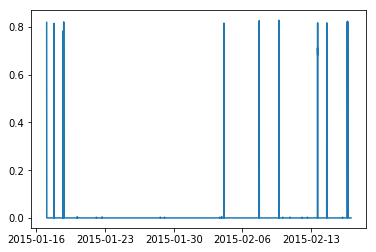

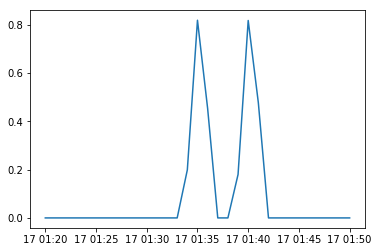

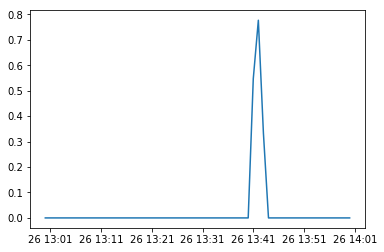

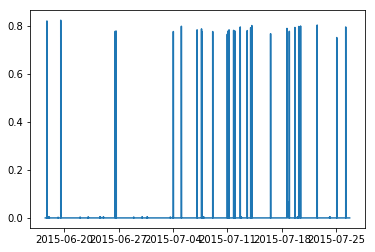

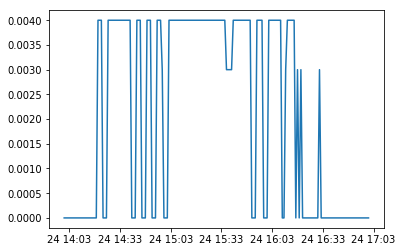

In [840]:
plt.figure(0)
plt.plot(data['kitchenapp1']['2015-01-17 01:35:00':'2015-02-17 01:35:00'])
plt.figure(1)
plt.plot(data['kitchenapp1']['2015-01-17 01:20:00':'2015-01-17 01:50:00'])
plt.figure(2)
plt.plot(data['kitchenapp1']['2015-06-26 13:00:00':'2015-06-26 14:00:00'])
plt.figure(3)
plt.plot(data['kitchenapp1']['2015-06-17 14:00:00':'2015-07-26 17:00:00'])
plt.figure(4)
plt.plot(data['kitchenapp1']['2015-06-24 14:00:00':'2015-06-24 17:00:00'])

In [841]:
data['kitchenapp1']['2015-06-24 14:00:00':'2015-06-24 17:00:00']

2015-06-24 14:00:00    0.000
2015-06-24 14:01:00    0.000
2015-06-24 14:02:00    0.000
2015-06-24 14:03:00    0.000
2015-06-24 14:04:00    0.000
2015-06-24 14:05:00    0.000
2015-06-24 14:06:00    0.000
2015-06-24 14:07:00    0.000
2015-06-24 14:08:00    0.000
2015-06-24 14:09:00    0.000
2015-06-24 14:10:00    0.000
2015-06-24 14:11:00    0.000
2015-06-24 14:12:00    0.000
2015-06-24 14:13:00    0.000
2015-06-24 14:14:00    0.000
2015-06-24 14:15:00    0.000
2015-06-24 14:16:00    0.000
2015-06-24 14:17:00    0.000
2015-06-24 14:18:00    0.000
2015-06-24 14:19:00    0.000
2015-06-24 14:20:00    0.004
2015-06-24 14:21:00    0.004
2015-06-24 14:22:00    0.004
2015-06-24 14:23:00    0.000
2015-06-24 14:24:00    0.000
2015-06-24 14:25:00    0.000
2015-06-24 14:26:00    0.004
2015-06-24 14:27:00    0.004
2015-06-24 14:28:00    0.004
2015-06-24 14:29:00    0.004
                       ...  
2015-06-24 16:31:00    0.003
2015-06-24 16:32:00    0.000
2015-06-24 16:33:00    0.000
2015-06-24 16:

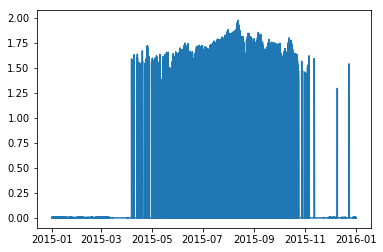

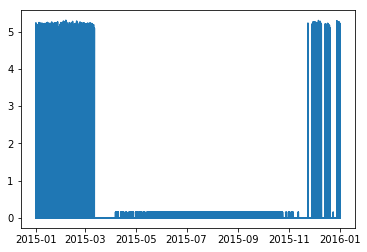

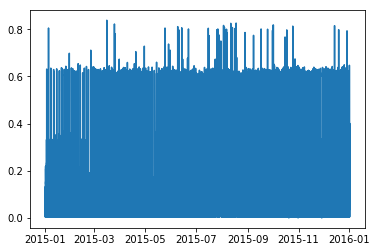

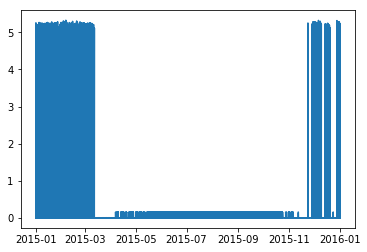

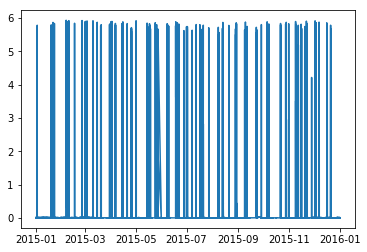

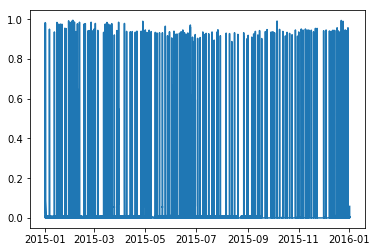

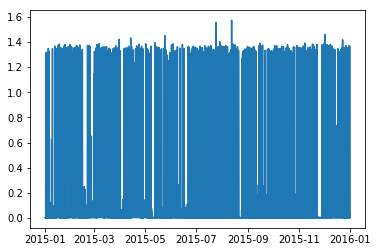

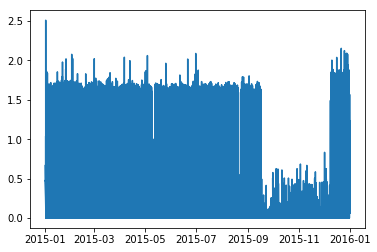

In [420]:
#np.where(data['refrigerator1'][0:600]==0.0) #100>
plt.plot(data['air1'])
plt.figure(2)
plt.plot(data['furnace1'])
plt.figure(3)
plt.plot(data['refrigerator1'])
plt.figure(4)
plt.plot(data['clotheswasher1'])
plt.figure(5)
plt.plot(data['drye1'])
plt.figure(6)
plt.plot(data['dishwasher1'])
plt.figure(7)
plt.plot(data['kitchenapp1'])
plt.figure(8)
plt.plot(data['microwave1'])

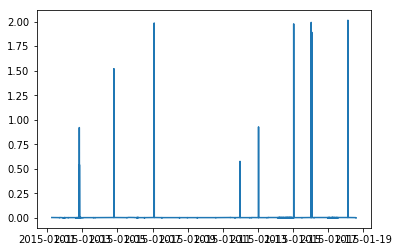

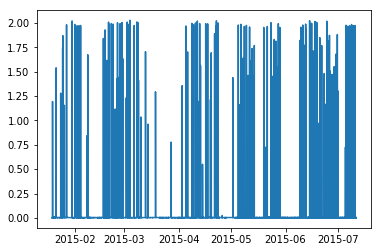

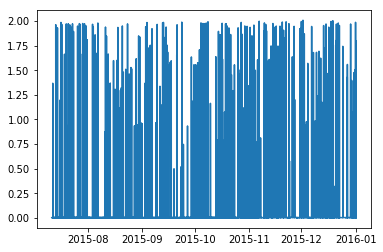

In [167]:
#data['air1'][0:600] # 0
data2 = data#.loc[data.index > ("2015-01-14")]
plt.plot(data2['microwave1'][0:25011])
plt.figure(2)
plt.plot(data2['microwave1'][25011:275125])
plt.figure(3)
plt.plot(data2['microwave1'][275125:])

In [185]:
#data['clotheswasher1'][0:600] # 0.0
#data2['dishwasher1'][263926:]
goodPlot = data.loc[ (data['air1']>1) & (data['microwave1']>0.5)& (data['microwave1']>0.2)& (data['clotheswasher1']>0.1)]


In [202]:
#data.index[0]
toPlot = data.loc['2015-08-20 01:00:00':'2015-08-20 02:00:00']
#toPlot.columns

Index([u'use', u'air1', u'furnace1', u'refrigerator1', u'clotheswasher1',
       u'drye1', u'dishwasher1', u'kitchenapp1', u'microwave1'],
      dtype='object')

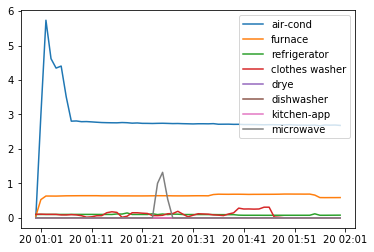

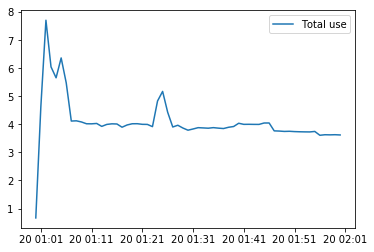

In [219]:
plt.figure(1)
plt.plot(toPlot.loc[:,toPlot.columns!='use'])
plt.legend(['air-cond','furnace','refrigerator','clothes washer','drye','dishwasher','kitchen-app','microwave'],loc=1)

plt.figure(2)
plt.plot(toPlot['use'])
plt.legend(['Total use'],loc=1)